## Imports

In [1]:
import cv2 as cv
import matplotlib.pyplot as plt
import numpy as np
from PIL import ImageFont, ImageDraw, Image

## Define palette of symbols to draw with
First we define the symbols we want to draw with.\
The first array are a subset the standard ascii symbols, special characters like ESC or BEL have been left out. \
The second array uses braille icons

In [2]:
ascii = [chr(c) for c in range(32, 127)]
ascii_str = ''.join(ascii)
print(ascii_str, "\n")

ascii = [chr(c) for c in range(10240, 10304)] # braille icons
braille_str = ''.join(ascii)
print(braille_str)

 !"#$%&'()*+,-./0123456789:;<=>?@ABCDEFGHIJKLMNOPQRSTUVWXYZ[\]^_`abcdefghijklmnopqrstuvwxyz{|}~ 

⠀⠁⠂⠃⠄⠅⠆⠇⠈⠉⠊⠋⠌⠍⠎⠏⠐⠑⠒⠓⠔⠕⠖⠗⠘⠙⠚⠛⠜⠝⠞⠟⠠⠡⠢⠣⠤⠥⠦⠧⠨⠩⠪⠫⠬⠭⠮⠯⠰⠱⠲⠳⠴⠵⠶⠷⠸⠹⠺⠻⠼⠽⠾⠿


## Draw palette symbols
A font in the `fonts` dir is loaded in. It's characters will be used to recreate an image later.\
**The font needs to contain the characters from the `ascii_str` defined above.**\
A superpixel size is defined. Characters are drawn within this superpixel, using PIL, and stored as a slice the `palette` tensor.\
Because the superpixel size is fixed, it is important to **use monospace fonts.**
The size of the superpixel is adjusted a few times so that the resulting characters all neatly fit into it.\
The font_size is also be adjusted as can influence the thickness or shape of the character.

In [3]:
def create_palette(characters, superpixel_size, font_displacement, font_size, font_path):
    font = ImageFont.truetype(font_path, font_size)
    palette_size = (len(characters), superpixel_size[0], superpixel_size[1])
    palette = np.zeros(palette_size, dtype=np.float32)

    for i, c in enumerate(characters):

        if i == 0:
            # The first character is a blank space
            image_text = np.zeros(superpixel_size, dtype=np.float32)

        else:
            image = Image.fromarray(np.zeros(superpixel_size))
            draw = ImageDraw.Draw(image)
            draw.text(font_displacement, c, font=font)
            image_text = np.array(image, dtype=np.float32)
            image_text = (image_text - image_text.min()) / (image_text.max() - image_text.min())

        palette[i] = image_text
    
    return palette

In [4]:
def show_palette(palette):
    width = 16
    size = ((len(ascii_str) // width) + 1, width)
    plt.figure(figsize=(16, 16))

    for i, image in enumerate(palette):
        plt.subplot(*size, i+1)
        plt.imshow(image, cmap = 'gray')

    plt.show()

In [8]:
ascii_superpixel_size = (22, 12)
ascii_displacement = (0, -2)
ascii_font_size = 18
ascii_font_path = "fonts/DejaVuSansMono.ttf"
ascii_palette = create_palette(ascii_str, ascii_superpixel_size, ascii_displacement, ascii_font_size, ascii_font_path)
show_palette(ascii_palette)

In [9]:
braille_superpixel_size = (18, 10)
braille_displacement = (0, 0)
braille_font_size = 20
braille_font_path = "fonts/TerminessNerdFontMono-Regular.ttf"
braille_palette = create_palette(braille_str, braille_superpixel_size, braille_displacement, braille_font_size, braille_font_path)
show_palette(braille_palette)

## Create image to ascii conversion pipeline

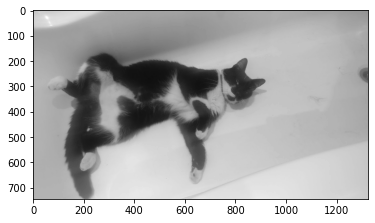

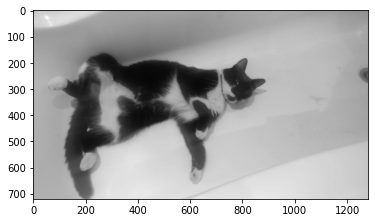

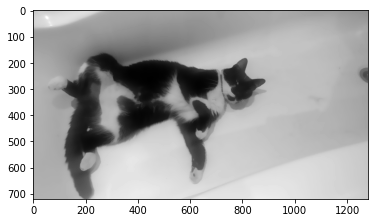

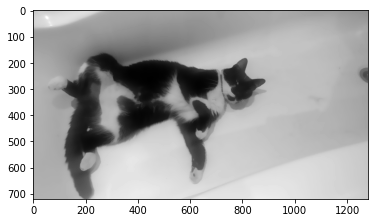

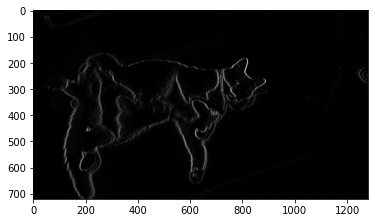

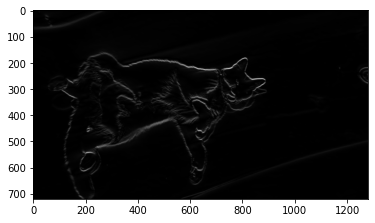

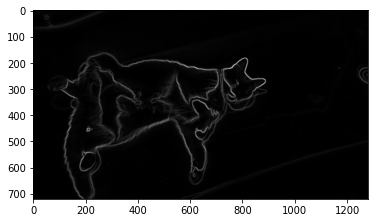

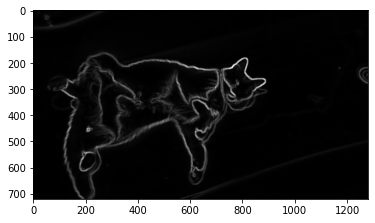

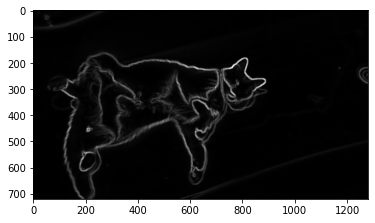

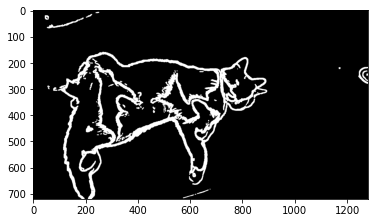

                  _ ~                                                                                     
    D         _a ^                                                                                        
     _____a#"`                                                                                            
     `                                                                                                    
                                                                                                          
                                                                                                          
                                                                                                          
                   __gmw__                                                                                
                 gF{     "L       ____________                   _a#y                                     
               gMB" _,     9g_amP"`  

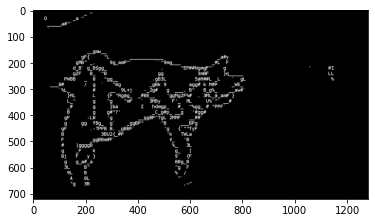

In [10]:
from pipeline import *

ascii_steps = [
    ResizeStep((1280, 720)),
    BilateralFilterStep(16, 8, 8),
    MinMaxNormalizeStep(),
    AddWeightedStep(
        SobelFilterStep(-1, 1, 0, 7),
        SobelFilterStep(-1, 0, 1, 7),
        weight1=0.5,
        weight2=0.5
    ),
    DilateStep(np.ones((3, 3)), 1),
    MinMaxNormalizeStep(),
    ThresholdStep(0.1, 1),
    AsciiStep(
        ascii_palette,
        ascii_str,
        ascii_superpixel_size,
        ascii_font_size,
        ascii_font_path
    )
]

source = FileSource("image/in/biscuit.jpg")
sink = FileSink("image/out/biscuit_ascii.jpg")
ascii_pipeline = Pipeline(ascii_steps, source, sink)
ascii_pipeline.show_process()